# Kaggle competition 1: Titanic

Okay so I'm going to use linear regression with the goal of predicting who perished in the Titanic. I have two datasets, a train dataset and a test dataset. 

Here's how I will approach the problem: 

I'll first combine both the training and 

0. Setup 
1. Preprocessing
    1. Non Numerical Data
        1. Categorical Data
        2. Extracting Data from ticket numbers
    2. Handling null cells
    3. Feature normalization (To be improved)
    4. Splitting into training and cross validation datasets
2. Logistic Regression 
    1. Implementing a logistic regression model 
    2. Parameter Optimization 
3. SVM (with a Gaussian Kernel) 
    1. Implementing SVM
    2. Parameter Optimization 
4. Making a submission file
    1. Deciding on which method to use
    2. Making the return file

## 0. Installing the necessary modules 

In [1]:
%matplotlib inline 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as p

#Using Scikit-Learn for the machine learning algorithms
from sklearn import linear_model 
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm

## 0.1 Downloading the data

In [2]:
train = pd.read_csv("train.csv") #contains whether or not the passengers survived
test = pd.read_csv("test.csv") # does not; this is to be submitted to Kaggle 
full = train.append( test , ignore_index = True ) #appends, ignoring the Survived column 
train.head() #hello, data! 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Preprocessing
### 1.1 Handling Categories
So, from the above graph, its clear that the following items are categorized instead of given numerical values: 
1. Name
2. Sex
3. Ticket 
4. Cabin 
5. Embarked

In order to do a run quickly, I'm going to clean up the 2 and 5th items. I'm also going to clean up the tickets, but this will be slightly more involved.

I'm also going to do everything to the train and test datasets, since my ultimate goal is to make predictions on the test dataset. 

#### 1.1.1 The Sex and Embarked Columns

In [3]:
train["Embarked"].replace(to_replace = ['C','S','Q'], value = [0.3,0.6,0.9], inplace=True);
train["Sex"].replace(to_replace=['male', 'female'], value = [0,1], inplace=True);

test["Embarked"].replace(to_replace = ['C','S','Q'], value = [0.3,0.6,0.9] ,inplace=True );
test["Sex"].replace(to_replace=['male', 'female'], value = [0,1],inplace=True );

#### 1.1.2 The Ticket Column
The ticket numbers can be split into two parts: 
1. The prefixes (which are optional) 
2. The numbers 

Because the prefixes aren't present in the entire dataset, and are heavily repeated, they are less likely to provide information than the ticket numbers, so I'm just going to extract those. 

In [4]:
train["StringTickets"] = train["Ticket"].astype(str)
train["StringTicketsSplit"] = train.StringTickets.str.split()
train.StringTicketsSplit = train.StringTicketsSplit.apply(lambda x: x[-1])
train.StringTicketsSplit = pd.to_numeric(train.StringTicketsSplit, errors='coerce', downcast = 'integer')
del train["StringTickets"] #This just cleans up an unnecessary column 

#And, for the test dataset too
test["StringTickets"] = test["Ticket"].astype(str)
test["StringTicketsSplit"] = test.StringTickets.str.split()
test.StringTicketsSplit = test.StringTicketsSplit.apply(lambda x: x[-1])
test.StringTicketsSplit = pd.to_numeric(test.StringTicketsSplit)
del test["StringTickets"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,StringTicketsSplit
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.6,21171.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.3,17599.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.6,3101282.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0.6,113803.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0.6,373450.0


### 1.2 Handling null cells 

The scikit method I'm going to be using doesn't like null cells in the input dataset. In order to best figure out how to approach these null cells, I'll need to plot them to get some idea of exacly what is missing. 

In [5]:
train.isnull().sum(), test.isnull().sum()

(PassengerId             0
 Survived                0
 Pclass                  0
 Name                    0
 Sex                     0
 Age                   177
 SibSp                   0
 Parch                   0
 Ticket                  0
 Fare                    0
 Cabin                 687
 Embarked                2
 StringTicketsSplit      4
 dtype: int64, PassengerId             0
 Pclass                  0
 Name                    0
 Sex                     0
 Age                    86
 SibSp                   0
 Parch                   0
 Ticket                  0
 Fare                    1
 Cabin                 327
 Embarked                0
 StringTicketsSplit      0
 dtype: int64)

Cabin has too many missing; I'm just going to ignore it. For "Embarked" and "StringTicketsSplit" and "Fare" I'm just going to use the mean, since the number of missing values (a grand total of 7) is too small to be worth spending more time on (for now). 

In [6]:
train['Embarked'].fillna(train['Embarked'].mean(), inplace = True)
train["StringTicketsSplit"].fillna(train["StringTicketsSplit"].mean(), inplace = True)

test["Fare"].fillna(test["Fare"].mean(), inplace = True)

train.isnull().sum(), test.isnull().sum()

(PassengerId             0
 Survived                0
 Pclass                  0
 Name                    0
 Sex                     0
 Age                   177
 SibSp                   0
 Parch                   0
 Ticket                  0
 Fare                    0
 Cabin                 687
 Embarked                0
 StringTicketsSplit      0
 dtype: int64, PassengerId             0
 Pclass                  0
 Name                    0
 Sex                     0
 Age                    86
 SibSp                   0
 Parch                   0
 Ticket                  0
 Fare                    0
 Cabin                 327
 Embarked                0
 StringTicketsSplit      0
 dtype: int64)

So the most significant missing category is Age; it also has a strong relationship with survival, so its worth properly accounting for: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a4a7410>]], dtype=object)

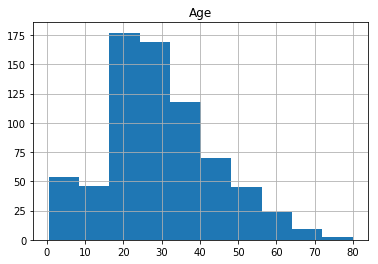

In [7]:
pd.DataFrame.hist(train, column = "Age")

(<matplotlib.axes._subplots.AxesSubplot at 0x11a701810>, 29.69911764705882)

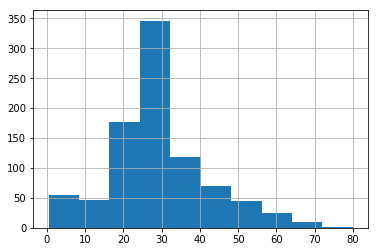

In [8]:
mean_test = train["Age"].copy()
filled = mean_test.fillna(mean_test.mean())
pd.Series.hist(filled), mean_test.mean()

So this pretty dramatically skews the data. What can I do about this? Is there a way I can use data I **do** have to predict what the value might have been? 

One way I could approach this is to use linear regression to predict the ages. Omg machine learning within machine learning. 

### Linear Regression to find Age

In [9]:
# Step 1; seperating the data into the training data (where Age != NaN), and the test data

lin_train = train[np.isfinite(train["Age"])]
lin_test = train[np.isfinite(train["Age"])==False]
lin_train.shape

(714, 13)

In [10]:
#Sweet; one last thing is to create a 'validation' dataset. I'll just shuffle the data and take the first
#100 points to be the validation data. 

shuffled = lin_train.sample(frac = 1)

X_train = shuffled.iloc[:int(len(shuffled.index)*0.75),:];
Y_train = shuffled["Age"].iloc[:int(len(shuffled.index)*0.75)];

X_cv = shuffled.iloc[int(len(shuffled.index)*0.75):,:];
Y_cv = shuffled["Age"].iloc[int(len(shuffled.index)*0.75):];

X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,StringTicketsSplit
590,591,0,3,"Rintamaki, Mr. Matti",0,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,0.6,3.101273e+06
884,885,0,3,"Sutehall, Mr. Henry Jr",0,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,0.6,3.920760e+05
120,121,0,2,"Hickman, Mr. Stanley George",0,21.0,2,0,S.O.C. 14879,73.5000,NaN,0.6,1.487900e+04
179,180,0,3,"Leonard, Mr. Lionel",0,36.0,0,0,LINE,0.0000,NaN,0.6,2.983284e+05
69,70,0,3,"Kink, Mr. Vincenz",0,26.0,2,0,315151,8.6625,NaN,0.6,3.151510e+05


B-E-A-utiful. 

I'm now going to run several linear regressions, to find out which datasets are the best predictors of Age. 

In [11]:
def error_vs_m_linreg(X_train, Y_train, X_cv, Y_cv, plot=True):
    error_cv = [];
    error_train = [];
    linreg = linear_model.LinearRegression();
    
    for m in range(10, len(X_train.index)-1):
        linreg.fit(X_train.iloc[:m,:], Y_train.iloc[:m]);
        error_cv.append(metrics.mean_absolute_error(linreg.predict(X_cv), Y_cv)); 
        error_train.append(metrics.mean_absolute_error(linreg.predict(X_train.iloc[:m,:]), Y_train.iloc[:m]));

    if plot: 
        m = range(10, len(X_train.index)-1);
        p.plot(m, error_cv, label = 'cv');
        p.plot(m, error_train, label = 'train');
        p.xlabel("Training set size")
        p.ylabel("Mean Absolute Error")
        p.legend()
        p.show()
    
    return error_cv[len(m)-1], error_train[len(m)-1]

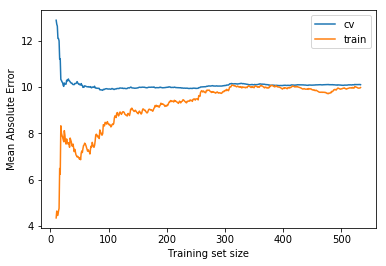

(10.105139729843895, 9.9816999776572164)

In [12]:
#First, testing the use of PClass and SibSp

X1 = X_train.iloc[:,[2,6]]
X1_cv = X_cv.iloc[:,[2,6]]

error_vs_m_linreg(X1, Y_train, X1_cv, Y_cv)


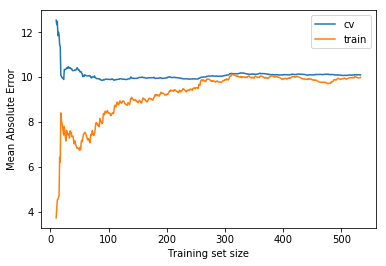

(10.094843972084258, 9.9866634933345946)

In [13]:
#Now, including Parch
X2 = X_train.iloc[:,[2,6,7]]
X2_cv = X_cv.iloc[:,[2,6,7]]

error_vs_m_linreg(X2, Y_train, X2_cv, Y_cv)

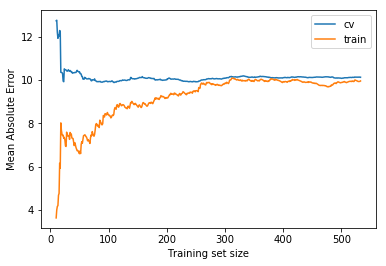

(10.122681274123826, 9.9520431064432735)

In [14]:
#And finally, including Fare
X3 = X_train.iloc[:,[2,6,7,9]]
X3_cv = X_cv.iloc[:,[2,6,7,9]]
error_vs_m_linreg(X3, Y_train, X3_cv, Y_cv)

Scenario 2 seems to do the best (although all performances are comparable); let's use this to get out Ages. 

In [15]:
#First, making the model: 
linreg = linear_model.LinearRegression()
linreg.fit(X2, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Okay; now lets use it to fill all the NaN values in the original dataset: 

In [19]:
for i in range(train.shape[0]): 
    if (np.isfinite(train["Age"][i])==False):
        Age_pred = linreg.predict(train.iloc[i, [2,6,7]].reshape(1,-1))[0]
        train.set_value(i, 'Age', Age_pred)

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,StringTicketsSplit
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.6,21171.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.3,17599.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.6,3101282.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0.6,113803.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0.6,373450.0


Oh boy! This is exciting! 

I also need to do this for the test dataset but !!! WARNING !!! the values are different since there isn't the survived class; I need to subtract one from each: 

In [20]:
test.iloc[1, [1,5,6,8]]
for i in range(test.shape[0]):
    if (np.isfinite(test["Age"][i])==False):
        Age_pred = linreg.predict(test.iloc[i, [1,5,6]].reshape(1,-1))[0]
        test.set_value(i, 'Age', Age_pred)

In [21]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,StringTicketsSplit
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,0.9,330911
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0.6,363272
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,0.9,240276
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0.6,315154
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0.6,3101298


In [22]:
train.isnull().sum(), test.isnull().sum()

(PassengerId             0
 Survived                0
 Pclass                  0
 Name                    0
 Sex                     0
 Age                     0
 SibSp                   0
 Parch                   0
 Ticket                  0
 Fare                    0
 Cabin                 687
 Embarked                0
 StringTicketsSplit      0
 dtype: int64, PassengerId             0
 Pclass                  0
 Name                    0
 Sex                     0
 Age                     0
 SibSp                   0
 Parch                   0
 Ticket                  0
 Fare                    0
 Cabin                 327
 Embarked                0
 StringTicketsSplit      0
 dtype: int64)

### 1.3 Feature scaling and mean normalization

Now, given the massive values of the ticket numbers, I also want to normalize them. For performance, lets normalize everything. 

I can't use scikit's preprocessing.MinMaxScaler because I didn't join the training and test sets, but I want them to be scaled (and normalized) in the same way. Therefore, I'm going to have to do it manually. Assuming they are fairly similar, I'm going to scale and normalize both using data from the training set. 

In [23]:
#First, mean normalization 
train.StringTicketsSplit = train.StringTicketsSplit.apply(lambda x: x - train.StringTicketsSplit.mean())
test.StringTicketsSplit = test.StringTicketsSplit.apply(lambda x: x - train.StringTicketsSplit.mean())
#Feature scaling the ticket numbers
ticket_max = train.StringTicketsSplit.max()
ticket_min = train.StringTicketsSplit.min()

train.StringTicketsSplit = train.StringTicketsSplit.apply(lambda x: (x-ticket_min)/(ticket_max-ticket_min))
test.StringTicketsSplit = test.StringTicketsSplit.apply(lambda x: (x-ticket_min)/(ticket_max-ticket_min))

#Mean normalization on the fare
train.Fare = train.Fare.apply(lambda x: x-train.Fare.mean())
test.Fare = test.Fare.apply(lambda x: x-train.Fare.mean())

#Feature scaling the fare
fare_max = train.Fare.max()
fare_min = train.Fare.min()

train.Fare = train.Fare.apply(lambda x: (x-fare_min)/(fare_max-fare_min))
test.Fare = test.Fare.apply(lambda x: (x-fare_min)/(fare_max-fare_min))

#Mean normalization of the ages
train.Age = train.Age.apply(lambda x: x-train.Age.mean())
test.Age = test.Age.apply(lambda x: x-train.Age.mean())

#Feature scaling the Ages
age_max = train.Age.max()
age_min = train.Age.min()

train.Age = train.Age.apply(lambda x: (x-age_min)/(age_max - age_min))
test.Age = test.Age.apply(lambda x: (x-age_min)/(age_max-age_min))



train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,StringTicketsSplit
0,1,0,3,"Braund, Mr. Owen Harris",0,0.335575,1,0,A/5 21171,0.014151,NaN,0.6,0.006825
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.518865,1,0,PC 17599,0.139136,C85,0.3,0.005674
2,3,1,3,"Heikkinen, Miss. Laina",1,0.381397,0,0,STON/O2. 3101282,0.015469,NaN,0.6,0.999989
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.484498,1,0,113803,0.103644,C123,0.6,0.036694
4,5,0,3,"Allen, Mr. William Henry",0,0.484498,0,0,373450,0.015713,NaN,0.6,0.120416


### 1.4 Seperating the cross validation and training sets
In order to do this, I want the data to be randomly seperated, so the first thing I'll do is shuffle the data row-wise. 

I'll then split it into a training and cross validation set, before isolating the columns which I'll be using to train the model (which will be all numerical columns). 

In [24]:
#To split the data, I first need to shuffle it
shuffled = train.sample(frac = 1); #By making frac=1, I shuffle it all
shuffled.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,StringTicketsSplit
175,176,0,3,"Klasen, Mr. Klas Albin",0,0.289753,1,1,350404,0.015330,NaN,0.6,0.112985
271,272,1,3,"Tornquist, Mr. William Henry",0,0.369942,0,0,LINE,0.000000,NaN,0.6,0.096193
63,64,0,3,"Skoog, Master. Harald",0,0.129374,3,2,347088,0.054457,NaN,0.6,0.111915
760,761,0,3,"Garfirth, Mr. John",0,0.402822,0,0,358585,0.028302,NaN,0.6,0.115623
401,402,0,3,"Adams, Mr. John",0,0.381397,0,0,341826,0.015713,NaN,0.6,0.110219


In [25]:
#Now that its shuffled, I want to split it 75:25 into the training and cross validation sets 
X_train = shuffled.iloc[:int(len(shuffled.index)*0.75),[2,4,5,6,7,9,11,12]];
Y_train = shuffled["Survived"].iloc[:int(len(shuffled.index)*0.75)];

X_cv = shuffled.iloc[int(len(shuffled.index)*0.75):,[2,4,5,6,7,9,11,12]];
Y_cv = shuffled["Survived"].iloc[int(len(shuffled.index)*0.75):];

print (X_train.shape), (Y_train.shape), (X_cv.shape), (Y_cv.shape)
#X_train.head()

(668, 8) (668,) (223, 8) (223,)


Okay; now the data is ready for a first run. Hooray! 

## 2. Logistic Regression 
### 2.1 Implementing Logistic Regression 

For this first run, all values are going to be left as default; optimization will happen later, once I get a feel for how the model does with these features. 

In [26]:
logreg = linear_model.LogisticRegression();
logreg.fit(X_train, Y_train)
print logreg.score(X_train, Y_train), logreg.score(X_cv, Y_cv)

0.802395209581 0.789237668161


Okay! Not bad, but there's work to be done. 
#### 2.1.1 - Plotting error against training dataset size 
The first step is to figure out exactly what these numbers mean. Are we overfitting or underfitting the data? 

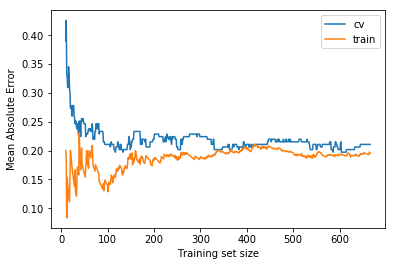

(0.21076233183856502,
 0.19519519519519518,
 0.73743016759776536,
 0.71827956989247321)

In [27]:
def error_vs_m_logreg(X_train, Y_train, X_cv, Y_cv, C=1, plot=True):
    error_cv = [];
    error_train = [];
    logreg = linear_model.LogisticRegression(C=C);
    for m in range(10, len(X_train.index)-1):
        logreg.fit(X_train.iloc[:m,:], Y_train.iloc[:m]);
        error_cv.append(metrics.mean_absolute_error(logreg.predict(X_cv), Y_cv)); 
        error_train.append(metrics.mean_absolute_error(logreg.predict(X_train.iloc[:m,:]), Y_train.iloc[:m]));

    if plot: 
        m = range(10, len(X_train.index)-1);
        p.plot(m, error_cv, label = 'cv');
        p.plot(m, error_train, label = 'train');
        p.xlabel("Training set size")
        p.ylabel("Mean Absolute Error")
        p.legend()
        p.show()
    
    f1_cv = metrics.f1_score(Y_cv, logreg.predict(X_cv))
    f1_train = metrics.f1_score(Y_train, logreg.predict(X_train))
    return error_cv[len(m)-1], error_train[len(m)-1], f1_cv, f1_train

error_vs_m_logreg(X_train, Y_train, X_cv, Y_cv)

So its clear that I'm underfitting the data. 

### 2.2 Parameter Optimization

Lets try optimizing C, since with $\lambda = 1$, its likely to be highly biased. I want to find the value of C for which the mean absolute error of the cross validation set is minimized. 

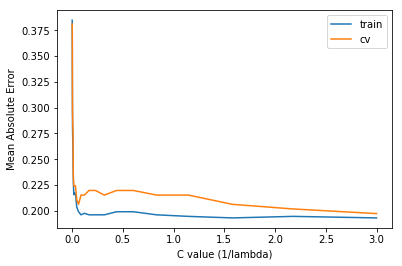

In [26]:
possible_C = np.logspace(-6, 1, num=25, base = 3);
def optimize_c_logreg(possible_C, X_train, Y_train, X_cv, Y_cv, plot = True):
    C_error_train = [];
    C_error_cv = [];
    for i in range(len(possible_C)):
        logreg = linear_model.LogisticRegression(C = possible_C[i])
        logreg.fit(X_train, Y_train);
        C_error_train.append(metrics.mean_absolute_error(logreg.predict(X_train), Y_train));
        C_error_cv.append(metrics.mean_absolute_error(logreg.predict(X_cv), Y_cv)); 
    if plot:
        p.plot(possible_C, C_error_train, label = 'train');
        p.plot(possible_C, C_error_cv, label = 'cv'); 
        p.xlabel("C value (1/lambda)")
        p.ylabel("Mean Absolute Error")
        p.legend()
        p.show()
    C_min = possible_C[np.argmin(C_error_cv)]
    return C_min

C_min = optimize_c_logreg(possible_C, X_train, Y_train, X_cv, Y_cv)
    

Now, lets try running the previous code with this parameter set

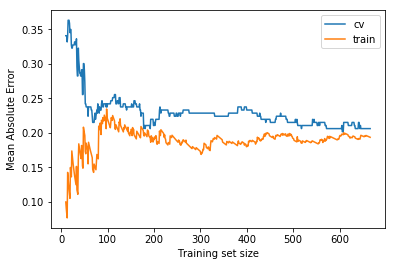

0.206278026906 0.193693693694 0.7125 0.738955823293


In [27]:
cv_error, train_error, f1_cv, f1_train = error_vs_m_logreg(X_train, Y_train, X_cv, Y_cv, C=C_min)
print cv_error, train_error, f1_cv, f1_train

## 3. Implementing Support Vector Machine

So I think one of the challenges with logistic regression is that the number of datapoints is quite small, as is the number of features. SVM should better handle this scale. 

### 3.1 Implementing SVM 

In [28]:
svm_model = svm.SVC();
svm_model.fit(X_train, Y_train);
print svm_model.score(X_train, Y_train), svm_model.score(X_cv, Y_cv)

0.815868263473 0.80269058296


This is excitingly better than Logistic Regression. Let's investigate

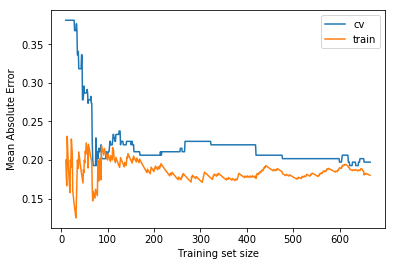

(0.19730941704035873,
 0.18018018018018017,
 0.71428571428571441,
 0.74844074844074848)

In [29]:
def error_vs_m_svc(X_train, Y_train, X_cv, Y_cv, C=1, plot=True):
    error_cv = [];
    error_train = [];
    svc = svm.SVC(C=C);
    for m in range(10, len(X_train.index)-1):
        svc.fit(X_train.iloc[:m,:], Y_train.iloc[:m]);
        error_cv.append(metrics.mean_absolute_error(svc.predict(X_cv), Y_cv)); 
        error_train.append(metrics.mean_absolute_error(svc.predict(X_train.iloc[:m,:]), Y_train.iloc[:m]));

    if plot: 
        m = range(10, len(X_train.index)-1);
        p.plot(m, error_cv, label = 'cv');
        p.plot(m, error_train, label = 'train');
        p.xlabel("Training set size")
        p.ylabel("Mean Absolute Error")
        p.legend()
        p.show()
    
    f1_cv = metrics.f1_score(Y_cv, svc.predict(X_cv))
    f1_train = metrics.f1_score(Y_train, svc.predict(X_train))
    return error_cv[len(m)-1], error_train[len(m)-1], f1_cv, f1_train

error_vs_m_svc(X_train, Y_train, X_cv, Y_cv)

Oh boy this is promising. Let's optimize the parameters for this using the cross validation dataset. 

### 3.2 Optimization

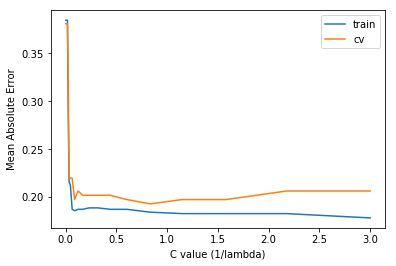

0.832683177656


In [30]:
possible_C = np.logspace(-6, 1, num=25, base = 3);
def optimize_c_svc(possible_C, X_train, Y_train, X_cv, Y_cv, plot = True):
    C_error_train = [];
    C_error_cv = [];
    for i in range(len(possible_C)):
        svc = svm.SVC(C = possible_C[i])
        svc.fit(X_train, Y_train);
        C_error_train.append(metrics.mean_absolute_error(svc.predict(X_train), Y_train));
        C_error_cv.append(metrics.mean_absolute_error(svc.predict(X_cv), Y_cv)); 
    if plot:
        p.plot(possible_C, C_error_train, label = 'train');
        p.plot(possible_C, C_error_cv, label = 'cv'); 
        p.xlabel("C value (1/lambda)")
        p.ylabel("Mean Absolute Error")
        p.legend()
        p.show()
    C_min = possible_C[np.argmin(C_error_cv)]
    return C_min

C_min = optimize_c_svc(possible_C, X_train, Y_train, X_cv, Y_cv)
print C_min

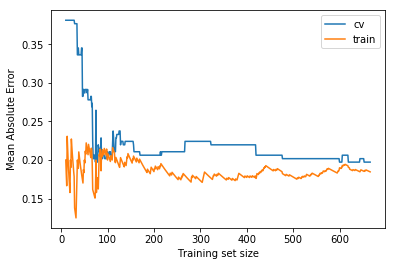

0.19730941704 0.184684684685 0.714285714286 0.740585774059


In [31]:
cv_error, train_error, f1_cv, f1_train = error_vs_m_svc(X_train, Y_train, X_cv, Y_cv, C=C_min)
print cv_error, train_error, f1_cv, f1_train

## 4. Making the submission file 
### 4.1 Choosing which method to use
It's pretty clear the SVM method is the way to go here. 
### 4.2 Making the submission file

In [32]:
#First, I need to make an X file for the test data
X_test = test.iloc[:,[1,3,4,5,6,8,10,11]];
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,StringTicketsSplit
0,3,0,0.809091,0,0,0.078140,0.9,0.202893
1,3,1,0.955995,1,0,0.076522,0.6,0.213328
2,2,0,1.132279,0,0,0.081767,0.9,0.173669
3,3,0,0.720948,0,0,0.079767,0.6,0.197813
4,3,1,0.662187,1,1,0.086842,0.6,1.096188


In [33]:
#Making the model, and training it 
svc = svm.SVC(C = C_min)
svc.fit(X_train, Y_train);

#Predicting the y values 
Y_test = svc.predict(X_test)

Y_test

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [34]:
submission = pd.read_csv("gender_submission.csv")
submission["Predicted"] = Y_test
submission.head()

,PassengerId,Survived,Predicted
0,892,0,0
1,893,1,1
2,894,0,0
3,895,0,0
4,896,1,1


In [35]:
row_ids = submission[submission["Predicted"] != submission["Survived"]].index
row_ids

Int64Index([69, 132, 140, 188, 214, 365], dtype='int64')

In [36]:
my_submission = pd.DataFrame(submission.PassengerId)
my_submission["Survived"] = Y_test
my_submission.head()

my_submission.to_csv('submission6.csv',index =False, encoding = 'utf-8')